In [10]:
from model import LyricsRNN
from data import LyricsDataset, padding_fn
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
def load_artist_vectors(filename):
    checkpoint = torch.load(filename, map_location=device)
    epoch = checkpoint['epoch']
    all_losses = checkpoint['losses']
    params = checkpoint['hyperparameters']
    Data = LyricsDataset(params.input_file, vocab_file=params.vocab_file, vocab_size=params.vocab_size,
                     chunk_size=params.chunk_size, max_len=params.max_seq_len,
                     use_artist=params.use_artist)
    ValData = LyricsDataset(re.sub('train', 'val', params.input_file), vocab_file=params.vocab_file,
                        chunk_size=params.chunk_size, use_artist=params.use_artist)
    val_dataloader = DataLoader(ValData, batch_size=params.batch_size, num_workers=1, collate_fn=padding_fn, drop_last=True)
    model = LyricsRNN(ValData.vocab_len, ValData.vocab_len, ValData.PAD_ID, batch_size=params.batch_size, n_layers=params.n_layers,
                  hidden_size=params.hidden_size, word_embedding_size=params.word_embedding_size,
                  use_artist=params.use_artist, embed_artist=params.embed_artist, num_artists=Data.num_artists,
                  artist_embedding_size=params.artist_embedding_size
                  )
    optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for var_name in model.state_dict():
        print(var_name)
    print(model.artist_encoder.weight)
    artist_labels = Data.artists
    arr = model.artist_encoder.weight.detach().numpy()
    embed_artists = {}
    for index, artist in enumerate(Data.artists):
        embed_artists[artist] = arr[index,:]
    print(embed_artists)
    return artist_labels, arr, embed_artists
    

In [12]:
def plot_tsne(artist_labels, arr):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(artist_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.xlim(x_coords.min()-10, x_coords.max()+10)
    plt.ylim(y_coords.min()-10, y_coords.max()+10)
    plt.figure()
    plt.show()

In [13]:
def plot_pca(artist_labels, arr):
    pca = PCA(n_components=2)
    Y = pca.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(artist_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-1, x_coords.max()+1)
    plt.ylim(y_coords.min()-1, y_coords.max()+1)
    plt.figure()
    

In [14]:
pairs = [['dolly-parton','b-b-king'], ['dolly-parton', 'chris-brown' ],['dolly-parton', 'elton-john' ],['dolly-parton', 'eminem' ]]

In [15]:
from scipy import linalg
def cos(vec1,vec2):
    return vec1.dot(vec2)/(linalg.norm(vec1)*linalg.norm(vec2))
def similarity(pairs, embed_artists):
    sim = {}
    for a, b in pairs:
        res = cos(embed_artists[a], embed_artists[b])
        sim[(a,b)] = res
        print(res,a,'and',b)
    print(sim)


In [16]:
artist_labels, arr, embed_artists = load_artist_vectors(filename='checkpoints/top5_embed/top5_embed-e00001.pt')

Using vocab file: lyrics/top_5.vocab
chunking lyrics
Using vocab file: lyrics/top_5.vocab
chunking lyrics
word_encoder.weight
artist_encoder.weight
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
linear.weight
linear.bias
Parameter containing:
tensor([[-1.8606e-01,  1.6052e-01,  3.4952e-01,  5.2555e-01, -2.3514e-02,
         -1.2669e-01, -2.8850e-01,  1.2240e+00, -8.9128e-01,  8.3911e-01,
         -1.1350e-01, -2.4853e-01,  8.5128e-03, -4.8675e-02,  6.3544e-02,
         -1.8741e-02,  1.4605e+00,  1.9761e-02,  2.7434e-01, -4.7750e-01,
         -6.5810e-01, -3.6663e-01, -3.1871e-01, -6.5205e-01, -2.1312e-01,
         -6.8385e-02, -1.0056e-01, -7.8525e-01, -6.4941e-01,  1.3290e-01,
          1.8655e-01, -1.0602e-02],
        [-4.8505e-02, -5.2322e-01,  8.2476e-03,  4.0443e-02, -6.4317e-02,
          1.6577e-02, -8.7891e-02,  3.2957e-01, -3.0641e-01, -4.2776e-01,
         -7.1477e-01, -2.2436e-01,  3.3901e-02, -5.3741e-01, -8.7559e-04,
         -2.8544e-01,  5.2698e-01,

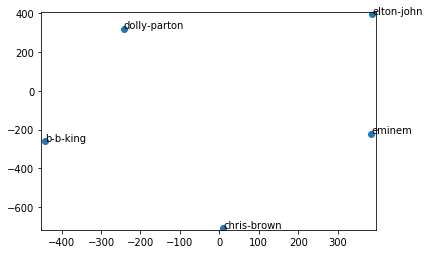

<Figure size 432x288 with 0 Axes>

In [17]:
plot_tsne(artist_labels, arr)

In [18]:
similarity(pairs, embed_artists)

0.42192354848846775 dolly-parton and b-b-king
0.22705191673792122 dolly-parton and chris-brown
0.21932815734156283 dolly-parton and elton-john
0.25414486453374174 dolly-parton and eminem
{('dolly-parton', 'b-b-king'): 0.42192354848846775, ('dolly-parton', 'chris-brown'): 0.22705191673792122, ('dolly-parton', 'elton-john'): 0.21932815734156283, ('dolly-parton', 'eminem'): 0.25414486453374174}
